#  General aspects of the pipeline 

In [1]:
%load_ext autoreload

import os 
import sys
import time
import logging
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from natsort import natsorted


sys.path.append(os.path.dirname(os.getcwd()))
from gridgene import get_arrays as ga
from gridgene import contours 
from gridgene import get_masks

sys.path.append(os.path.dirname(os.getcwd()))
from gridgene import get_arrays as ga
from gridgene import contours, get_masks 
from gridgene.mask_properties import MaskAnalysisPipeline, MaskDefinition
from gridgene.binsom import GetBins, GetContour

define the logger :  can be None, and is set to INFO

In [2]:
# define the logger :  can be None, and is set to INFO
# Custom logger setup
logger = logging.getLogger('contour_logger')
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

Get the files

In [3]:
xenium_path =  '../../xenium_data/HLA/GD_TMA1_S3/fov_filtered'

to_exclude = [
    'TMA1_Selection14_filtered.csv' , # little tumour
    'TMA1_Selection15_filtered.csv', # tonsil
    'TMA1_Selection18_filtered.csv' , # normal
    'TMA1_Selection24_filtered.csv', # tonsl 
    'TMA1_Selection27_filtered.csv', # low quality
    'TMA1_Selection32_filtered.csv', # low quality
    'TMA1_Selection33_filtered.csv', # low quality
             ]
files_tma1 = os.listdir(xenium_path)
files = [os.path.join(xenium_path, file) for file in files_tma1 if file not in to_exclude]
print(len(files))

20


# 1. Define Cancer Stroma based on density of genes

This intends to based on defined genes to find tumour areas and empty areas.
The stroma/other is defined as the area that is not empty and not tumour. 

We need to define: 

1. Parameters for tumour contours
    * Genes to consider :
  Use the marker genes of the gene list with log fold changes for epithelial cells
  
    * density
    * minimum area
    * kernel size
    
    this will define for an overlapping area with "kernel size" * "kernel_size" a minimum number of "density" genes of interest. The contiguous area of the contour will have at least "minimum area" 
 
2. Parameters for emptyness contours
    * density
    * minimum area
    * kernel size
   this will define for an overlapping area with "kernel size" * "kernel_size" a maximum number of "density"/ counts of all genes. The contiguous area of the contour will have at least "minimum area" 

In [4]:
# defined with the gene list f
target_tum = ['EPCAM', 'SMIM22','CLDN3', 'KRT18','LGALS4', 'KRT8', 'ELF3','TSPAN8', 'STMN1', 'CD47', 'MYC', 'LGALS3'] 

# param tum
density_th_tum = 25    # 50
min_area_th_tum =  500 #1000     check how much is a cell 
kernel_size_tum = 20   # 20

# param empty
density_th_empty = 20
min_area_th_empty = 50 #400
kernel_size_empty = 10

density_th_tum = 25    # 50
min_area_th_tum = 200
kernel_size_tum = 20   # 20

# param empty
density_th_empty = 20
min_area_th_empty = 400
kernel_size_empty = 10

grab data and derive arrays

In [5]:
file_csv = files[7]
df_total = pd.read_csv(file_csv)
df_total = df_total[['x_location', 'y_location', 'feature_name']]
df_total = df_total.rename(columns={'feature_name': 'target'})
df_total = df_total[~df_total['target'].str.contains('System|egative')]
df_total['X'] = df_total['x_location'] - min(df_total['x_location'])
df_total['Y'] = df_total['y_location'] - min(df_total['y_location'])

n_genes = len(df_total['target'].unique())
height = int(max(df_total['X'])) + 1
width = int(max(df_total['Y'])) + 1

print(f'n genes: {n_genes}')
print(f'shape: {height}, {width}')
print(f'n hits {len(df_total)}')

# this makes the sparse df to an array with the spatial information 
target_dict_total = {target: index for index, target in enumerate(df_total['target'].unique())}
array_total = ga.transform_df_to_array(df = df_total, target_dict=target_dict_total, array_shape = (height, width,len(target_dict_total))).astype(np.int8)

# creating subsets 
df_subset_tum, array_subset_tum, target_indices_subset_tum = ga.get_subset_arrays(df_total, array_total,target_dict_total,
                                                                     target_list=target_tum, target_col = 'target')


n genes: 480
shape: 1809, 1769
n hits 4433228


In [6]:
CTum = contours.ConvolutionContours(array_subset_tum, contour_name='tum')
CTum.get_conv_sum(kernel_size=kernel_size_tum, kernel_shape='square')
CTum.contours_from_sum(density_threshold = density_th_tum,
                       min_area_threshold = min_area_th_tum , directionality = 'higher')

CEmpty = contours.ConvolutionContours(array_total, contour_name='empty')
CEmpty.get_conv_sum(kernel_size=kernel_size_empty, kernel_shape='square')
CEmpty.contours_from_sum(density_threshold = density_th_empty,
                       min_area_threshold = min_area_th_empty, directionality = 'lower') # attention that directionality is lower here 

2025-06-20 15:16:41,914 - gridgen.contours.tum - INFO - Initialized GetContour
2025-06-20 15:16:41,996 - gridgen.contours.tum - INFO - get_conv_sum took 0.0809 seconds
2025-06-20 15:16:42,085 - gridgen.contours.tum - INFO - Number of contours after filtering no counts: 44
2025-06-20 15:16:42,085 - gridgen.contours.tum - INFO - contours_from_sum took 0.0889 seconds
2025-06-20 15:16:42,086 - gridgen.contours.empty - INFO - Initialized GetContour
2025-06-20 15:16:42,758 - gridgen.contours.empty - INFO - get_conv_sum took 0.6722 seconds
2025-06-20 15:16:43,406 - gridgen.contours.empty - INFO - Number of contours after filtering no counts: 20
2025-06-20 15:16:43,406 - gridgen.contours.empty - INFO - contours_from_sum took 0.6472 seconds


Plot contours

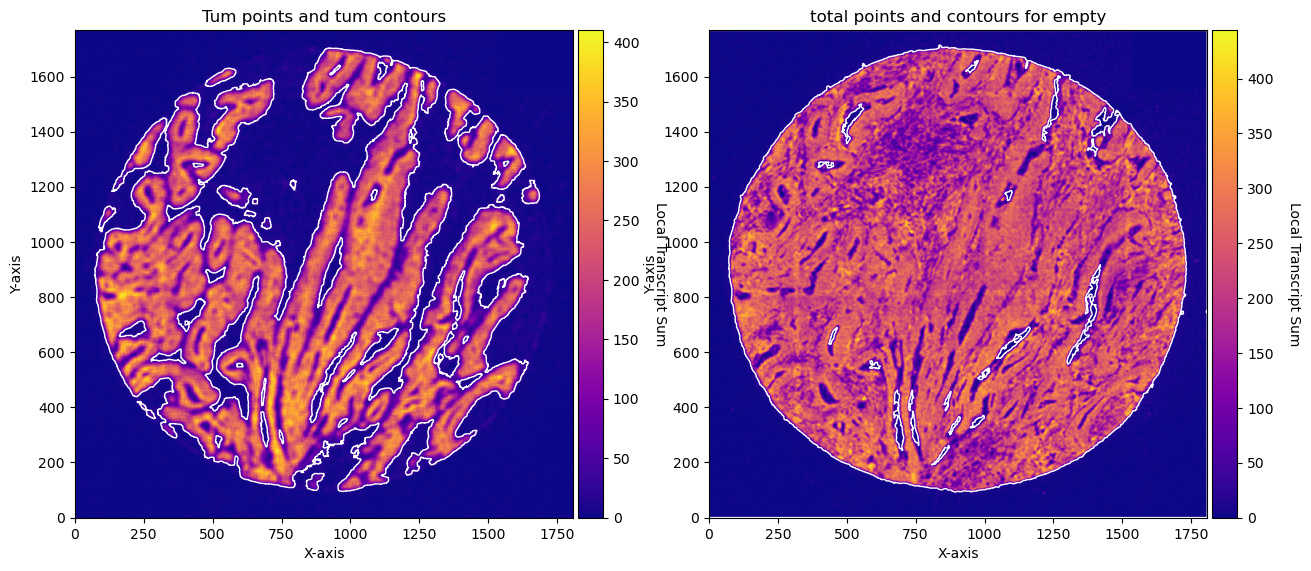

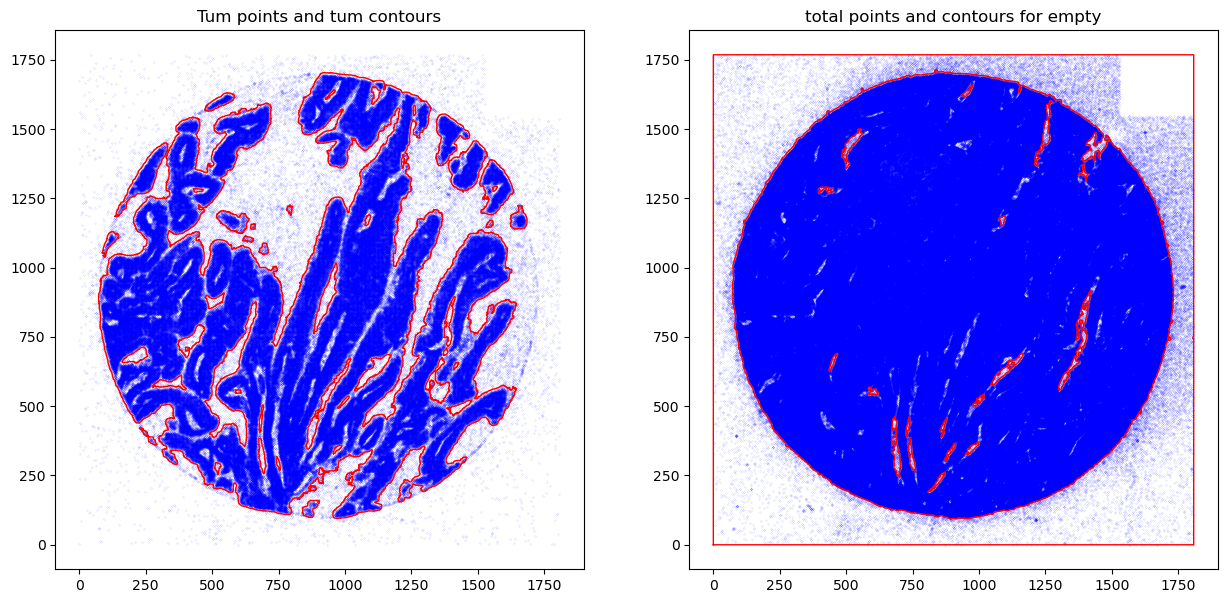

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

CTum.plot_conv_sum(cmap='plasma', c_countour='white', ax=axs[0])
axs[0].set_title('Tum points and tum contours')

CEmpty.plot_conv_sum(cmap='plasma', c_countour='white', ax=axs[1])
axs[1].set_title('total points and contours for empty')

plt.show()


fig, axs = plt.subplots(1, 2, figsize=(15, 7))

CTum.plot_contours_scatter(path=None, show=False, s=0.05, alpha=0.5, linewidth=1,
                           c_points= 'blue',c_contours= 'red', ax=axs[0])
axs[0].set_title('Tum points and tum contours')  

CEmpty.plot_contours_scatter(path=None, show=False, s=0.05, alpha=0.5, linewidth=1,
                               c_points= 'blue',c_contours= 'red', ax=axs[1])
axs[1].set_title('total points and contours for empty')  

plt.show()

Once you define your parameters of contours you can transform into masks,and obtain, in this case, masks for cancer, stroma and empty areas.  
The stroma mask from this analysis is the stroma minus the cancer. 

To obtain masks you need to have the contours. 

2025-06-20 15:16:45,489 - gridgen.get_masks.GetMasks - INFO - Initialized GetMasks
2025-06-20 15:16:45,516 - gridgen.get_masks.GetMasks - INFO - Subtracted masks from base mask.


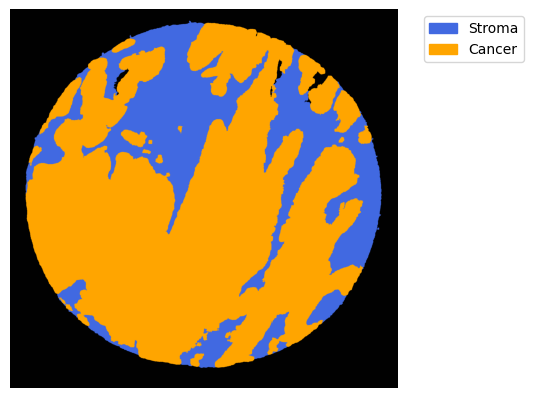

In [8]:
#### obtain masks
GM = get_masks.GetMasks(image_shape = (height, width))

mask_empty = GM.create_mask(CEmpty.contours)
mask_tum = GM.create_mask(CTum.contours)
mask_tum = GM.fill_holes(mask_tum)
mask_stroma = GM.subtract_masks(np.ones((height, width), dtype=np.uint8), mask_tum, mask_empty)          
mask_stroma = GM.filter_binary_mask_by_area(mask_stroma, min_area=700)


GM.plot_masks(masks=[mask_stroma, mask_tum], mask_names=['Stroma', 'Cancer'],
              background_color=(1, 1, 1),
              mask_colors={'Stroma': (65, 105, 225), 'Cancer': (255, 165, 0)},
              figsize = (5,5),
              path=None, show=True, ax=None)

From these we can expand a mask of interest and check their surroundings. In this case we will expand the cancer mask and obtain the interface border masks.

the expansion is given in pixels, so be aware, as in xenium the resolution is approx 1px = 1um so, expansions of 5,10,15,20 would be 5,10,15,20. 

2025-06-20 15:16:45,792 - gridgen.get_masks.GetMasks - INFO - Initialized GetMasks


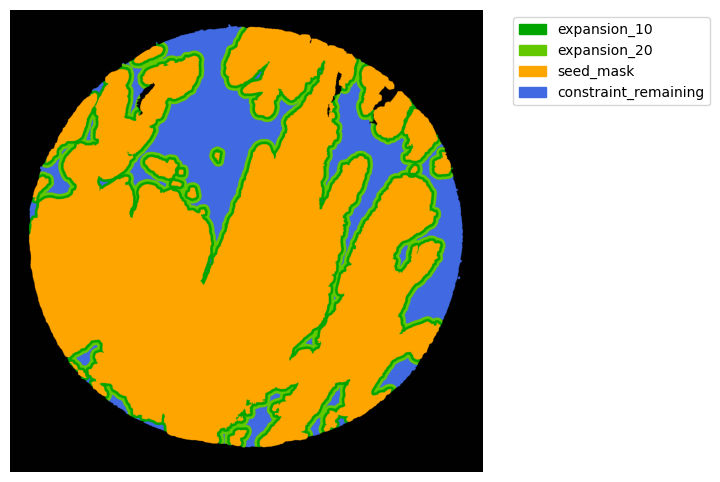

In [9]:
TA = get_masks.ConstrainedMaskExpansion(mask_tum, mask_stroma)
TA.expand_mask(expansion_pixels=[10,20], min_area=1000)

# change names and colos«rs! 
mask_colors = {'expansion_10':(0, 165, 0),
               'expansion_20':(100, 200, 0),
               'seed_mask':(255, 165, 0),
               'constraint_remaining':(65, 105, 225) } # Strom}

GM.plot_masks(masks=TA.binary_expansions.values(),
              mask_names=TA.binary_expansions.keys(),
              background_color=(1, 1, 1), mask_colors=mask_colors, path=None, show=True, ax=None,
             figsize=(8, 6))


Finally we can extract the information from the masks

We have several alternatives here. We can run this analysis:
    * per object in each mask
    * per mask, where all the objects of each mask are agglomerated. 
    * per grid. divides each object in a grid size and extracts the information based on this grid. This means the counts are based on objects with same size. 

You can get:

    * Counts
    * Morphological characteristics 


Per mask. run analysis type = 'bulk'

In [10]:
# 1. Define your masks using MaskDefinition
mask_definitions = [
    MaskDefinition(mask=TA.binary_expansions['constraint_remaining'], mask_name='Stroma_remaining', analysis_type='bulk'),
    MaskDefinition(mask=TA.binary_expansions['seed_mask'], mask_name='Cancer', analysis_type='bulk'),
    MaskDefinition(mask=TA.binary_expansions['expansion_10'], mask_name='CI_10um', analysis_type='bulk'),
    MaskDefinition(mask=TA.binary_expansions['expansion_20'], mask_name='CI_20um', analysis_type='bulk'),
]

# 2. Initialize and run the analysis pipeline
pipeline = MaskAnalysisPipeline(mask_definitions=mask_definitions, 
                                array_counts = array_total,
                        target_dict = target_dict_total,
  )
results = pipeline.run()
df = pipeline.get_results_df()
df

2025-06-20 15:16:46,665 - gridgen.mask_properties.GetMasks - INFO - Initialized MaskAnalysisPipeline with 4 masks.
2025-06-20 15:16:46,666 - gridgen.mask_properties.GetMasks - INFO - Processing mask: Stroma_remaining (bulk)
2025-06-20 15:16:47,099 - gridgen.mask_properties.GetMasks - INFO - Processing mask: Cancer (bulk)
2025-06-20 15:16:47,943 - gridgen.mask_properties.GetMasks - INFO - Processing mask: CI_10um (bulk)
2025-06-20 15:16:48,341 - gridgen.mask_properties.GetMasks - INFO - Processing mask: CI_20um (bulk)


run took 2.0489 seconds


,area,object_id,SPARC,VIM,KRT18,EPCAM,COL4A2,CEACAM1,KRT8,FCER1G,...,TNFRSF18,COL4A5,IL22RA2,IGHA2,CD45RA,IGHD,LST1,VPREB3,mask_name,analysis_type
0,313448,bulk,57272,12381,723,895,4292,151,445,1326,...,1,18,8,6,0,4,1,0,Stroma_remaining,bulk
1,1490024,bulk,58867,23990,183020,240049,7417,34765,59454,6946,...,7,31,64,13,3,11,8,5,Cancer,bulk
2,160338,bulk,28922,7273,1029,1025,3087,127,395,1330,...,1,4,9,0,1,1,1,0,CI_10um,bulk
3,118916,bulk,22367,5109,364,411,2041,66,174,812,...,1,3,7,3,0,0,2,0,CI_20um,bulk


Per object in each mask, run analysis type = 'object'

In [11]:
# 1. Define your masks using MaskDefinition
mask_definitions = [
    MaskDefinition(mask=TA.binary_expansions['constraint_remaining'], mask_name='Stroma_remaining', analysis_type='per_object'),
    MaskDefinition(mask=TA.binary_expansions['seed_mask'], mask_name='Cancer', analysis_type='per_object'),
    MaskDefinition(mask=TA.binary_expansions['expansion_10'], mask_name='CI_10um', analysis_type='per_object'),
    MaskDefinition(mask=TA.binary_expansions['expansion_20'], mask_name='CI_20um', analysis_type='per_object'),
]

# 2. Initialize and run the analysis pipeline
pipeline = MaskAnalysisPipeline(mask_definitions=mask_definitions, 
                                array_counts = array_total,
                        target_dict = target_dict_total,
  )
results = pipeline.run()
df = pipeline.get_results_df()
df

2025-06-20 15:16:48,730 - gridgen.mask_properties.GetMasks - INFO - Initialized MaskAnalysisPipeline with 4 masks.
2025-06-20 15:16:48,731 - gridgen.mask_properties.GetMasks - INFO - Processing mask: Stroma_remaining (per_object)
2025-06-20 15:16:49,625 - gridgen.mask_properties.GetMasks - INFO - Processing mask: Cancer (per_object)
2025-06-20 15:16:51,203 - gridgen.mask_properties.GetMasks - INFO - Processing mask: CI_10um (per_object)
2025-06-20 15:16:51,987 - gridgen.mask_properties.GetMasks - INFO - Processing mask: CI_20um (per_object)


run took 3.8931 seconds


,object_id,area,perimeter,eccentricity,solidity,centroid_y,centroid_x,min_row,min_col,max_row,...,TNFRSF18,COL4A5,IL22RA2,IGHA2,CD45RA,IGHD,LST1,VPREB3,mask_name,analysis_type
0,1,1085.0,169.018290,0.922395,0.847656,85.949309,1004.500461,75,970,102,...,0,0,0,0,0,0,0,0,Stroma_remaining,per_object
1,2,5981.0,503.972655,0.860329,0.536028,178.083264,1118.782812,115,1065,231,...,0,0,0,1,0,0,0,0,Stroma_remaining,per_object
2,3,163.0,71.805087,0.969076,0.724444,205.773006,1228.509202,197,1213,222,...,0,0,0,0,0,0,0,0,Stroma_remaining,per_object
3,4,1.0,0.000000,0.000000,1.000000,222.000000,429.000000,222,429,223,...,0,0,0,0,0,0,0,0,Stroma_remaining,per_object
4,5,2068.0,257.806133,0.890013,0.704360,290.335106,439.647002,254,407,334,...,0,0,0,0,0,0,0,0,Stroma_remaining,per_object
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,9,4752.0,965.637698,0.973810,0.409549,1211.740109,239.376684,1137,137,1278,...,0,0,0,0,0,0,0,0,CI_20um,per_object
92,10,26114.0,5598.663669,0.933984,0.140772,1328.682699,1136.854254,1198,606,1544,...,1,1,0,1,0,0,0,0,CI_20um,per_object
93,11,3225.0,700.607214,0.954404,0.282771,1463.885891,375.604961,1392,304,1564,...,0,0,0,0,0,0,0,0,CI_20um,per_object
94,12,14234.0,3016.399421,0.969164,0.140111,1578.050232,866.546930,1476,553,1666,...,0,1,0,0,0,0,0,0,CI_20um,per_object


Grid in each mask, run analysis type = 'grid'. You shoudl also give a grid size omm this case

In [12]:
# 1. Define your masks using MaskDefinition
mask_definitions = [
    MaskDefinition(mask=TA.binary_expansions['constraint_remaining'], mask_name='Stroma_remaining', analysis_type='grid', grid_size = 10),
    MaskDefinition(mask=TA.binary_expansions['seed_mask'], mask_name='Cancer', analysis_type='grid', grid_size = 10),
    MaskDefinition(mask=TA.binary_expansions['expansion_10'], mask_name='CI_10um', analysis_type='grid', grid_size = 10),
    MaskDefinition(mask=TA.binary_expansions['expansion_20'], mask_name='CI_20um', analysis_type='grid', grid_size = 10),
]

# 2. Initialize and run the analysis pipeline
pipeline = MaskAnalysisPipeline(mask_definitions=mask_definitions, 
                                array_counts = array_total,
                        target_dict = target_dict_total,
  )
results = pipeline.run()
df = pipeline.get_results_df()
df

2025-06-20 15:16:52,653 - gridgen.mask_properties.GetMasks - INFO - Initialized MaskAnalysisPipeline with 4 masks.
2025-06-20 15:16:52,654 - gridgen.mask_properties.GetMasks - INFO - Processing mask: Stroma_remaining (grid)
2025-06-20 15:16:54,628 - gridgen.mask_properties.GetMasks - INFO - Processing mask: Cancer (grid)
2025-06-20 15:17:01,002 - gridgen.mask_properties.GetMasks - INFO - Processing mask: CI_10um (grid)
2025-06-20 15:17:02,317 - gridgen.mask_properties.GetMasks - INFO - Processing mask: CI_20um (grid)


run took 10.6772 seconds


,x,y,object_id,area,centroid_x,centroid_y,SPARC,VIM,KRT18,EPCAM,...,TNFRSF18,COL4A5,IL22RA2,IGHA2,CD45RA,IGHD,LST1,VPREB3,mask_name,analysis_type
0,1020,100,1,39,975.000000,77.282051,2,0,0,0,...,0,0,0,0,0,0,0,0,Stroma_remaining,grid
1,1020,100,1,45,984.777778,77.222222,2,0,0,0,...,0,0,0,0,0,0,0,0,Stroma_remaining,grid
2,1020,100,1,40,994.525000,77.475000,2,0,0,0,...,0,0,0,0,0,0,0,0,Stroma_remaining,grid
3,1020,100,1,49,1004.408163,77.040816,2,0,0,0,...,0,0,0,0,0,0,0,0,Stroma_remaining,grid
4,1020,100,1,33,1014.000000,77.787879,2,0,0,0,...,0,0,0,0,0,0,0,0,Stroma_remaining,grid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25838,1140,1690,13,70,1133.414286,1685.457143,0,0,0,0,...,0,0,0,0,0,0,0,0,CI_20um,grid
25839,1140,1690,13,8,1141.125000,1688.375000,0,0,0,0,...,0,0,0,0,0,0,0,0,CI_20um,grid
25840,1140,1690,13,3,1128.666667,1690.333333,0,0,0,0,...,0,0,0,0,0,0,0,0,CI_20um,grid
25841,1140,1690,13,43,1134.581395,1691.720930,0,0,0,0,...,0,0,0,0,0,0,0,0,CI_20um,grid


In [13]:
df['area'].value_counts()

area
100    16321
1        323
2        212
6        199
3        196
       ...  
54        65
46        64
67        63
68        60
32        60
Name: count, Length: 100, dtype: int64

TA retrieves multiple mask dicts:
    * binary_expansions: with binary masks
    * labeled_expansions: with labelled object
    * referenced_objects: for hierarchy analysis 

We can plot the masks simply just as with simple colors.
There is also a function in GM to plot labelled masks with bounding boxes. 

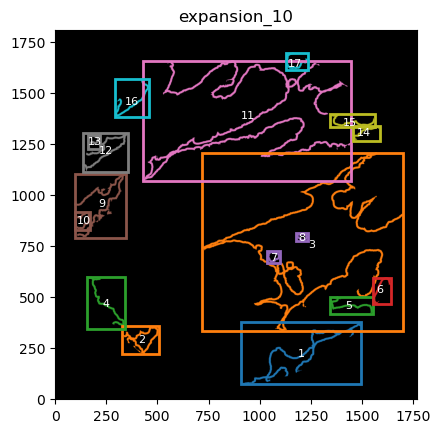

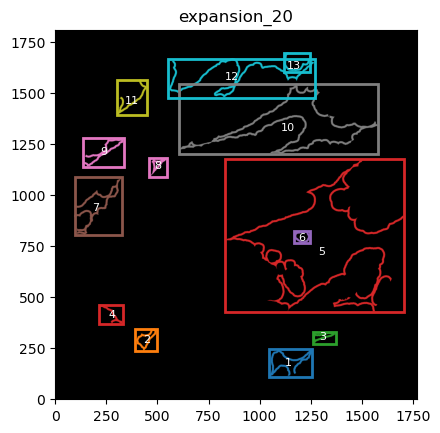

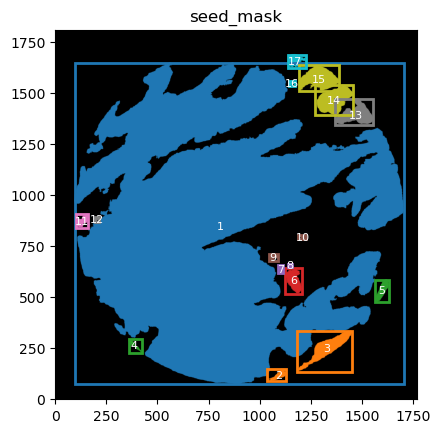

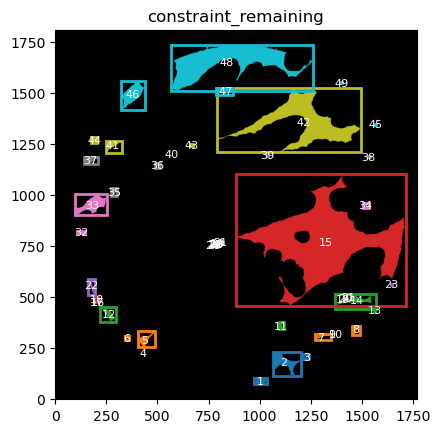

In [19]:
for mask in TA.labeled_expansions:
    labeled_mask = TA.labeled_expansions[mask]
    GM.plot_labeled_masks(label_mask=labeled_mask,
                       mask_name = mask, show=False)


you can now define the parameters that best suit the full cohort to define the contours and run for all files int he cohort.

Considerations:

probably set logger to write so a file with all the logging save to a report file ( get the file to a single core or do a single file for all the cohort is up to you) 
save the images and plots that may be necessary for the analysis later. Plotting and save takes time, but in some cases may be saving time to prevent you to redo analysis to obtain a figure. 

# How the same analysis look like using SOM. 

Bin the image and aply a SOM cluster
Each image is analysed separately

In [16]:
# Extract the filename without extension
filename = os.path.basename(file_csv).split('.')[0]

# Extract the desired part
name_file = '_'.join(filename.split('_')[:2])

We will get the bins defined in bin size from a list of df. In this case just one df of an image

These bins are not overlapping

The counts of eachbin with all the space information are saved in an adata object. 

Preprocess bin applies single cell normalization oipeline to the bin information ( normalize total and log1) and filters out empty bins <10 counts.

In [20]:
bin_size = 5  # 10
min_counts = 10 # 10
unique_targets = df_total['target'].unique()

GB = GetBins(bin_size, unique_targets, logger)
GB.get_bin_cohort(df_list= [df_total], df_name_list = [name_file], cohort_name = 'HLA')
GB.preprocess_bin(min_counts = min_counts)
adata = GB.adata

2025-06-20 15:31:54,159 - contour_logger - INFO - Time to get bins for 1 dataframes: 1.93 seconds
2025-06-20 15:31:54,159 - contour_logger - INFO - Number of bins: 99374
2025-06-20 15:31:54,159 - contour_logger - INFO - Number of genes: 480


Now that we have the bins of the images. We can apply a SOM cluster. we will apply a SOM map with 2 cells, and see if it accurately divides tumour from stroma due to their big differences. 

In [21]:
GC = GetContour(adata, logger)
GC.run_som(som_shape = (2,1), n_iter = 5000, sigma=.5, learning_rate=.5, random_state = 42)

2025-06-20 15:32:22,804 - contour_logger - INFO - Time to run som on 78461 bins: 0.93
2025-06-20 15:32:22,805 - contour_logger - INFO - Number of clusters: 2
2025-06-20 15:32:22,806 - contour_logger - INFO - number of bins in each cluster: cluster_som
0    42722
1    35739
Name: count, dtype: int64


As one can see this is almost instaneously. We can eval the differentially gene expression. one can use the GC.adata object and run preferred analysis. You can also use GC.eval_som_statistical

In [22]:
GC.eval_som_statistical(top_n=10)

2025-06-20 15:32:27,736 - contour_logger - INFO - n top genes for group 0
2025-06-20 15:32:27,738 - contour_logger - INFO - 
     names      scores  logfoldchanges  pvals  pvals_adj group
0    EPCAM  496.127167        4.710810    0.0        0.0     0
1    KRT18  401.328308        4.123829    0.0        0.0     0
2     LCN2  350.054199        4.303699    0.0        0.0     0
3     KRT8  204.175812        3.766609    0.0        0.0     0
4    CCL20  203.358932        3.733404    0.0        0.0     0
5      CA9  167.450836        4.739976    0.0        0.0     0
6    BIRC3  165.406113        3.378658    0.0        0.0     0
7    HLA-G  163.212875        1.587320    0.0        0.0     0
8   IFITM1  163.142197        2.525657    0.0        0.0     0
9  CEACAM1  161.894699        4.590243    0.0        0.0     0
2025-06-20 15:32:27,743 - contour_logger - INFO - n top genes for group 1
2025-06-20 15:32:27,745 - contour_logger - INFO - 
     names      scores  logfoldchanges  pvals  pvals_adj 

From the genes it appears that is separating bins based n stroma/ tumour . 

Let's see graphicaly

    we can see in two different ways. one is to transform the bins into an image again using GC.get_som_2d_image(bin_size = 10) and plot it with GC.plot_som. 

    The other option is to use squidpy and the centroids information stored in the adata object. In this one only the centroids are plotted ( but all the bins have the same size) 

/home/martinha/miniconda3/envs/GRIDGEN/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/martinha/miniconda3/envs/GRIDGEN/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


TMA1_Selection22


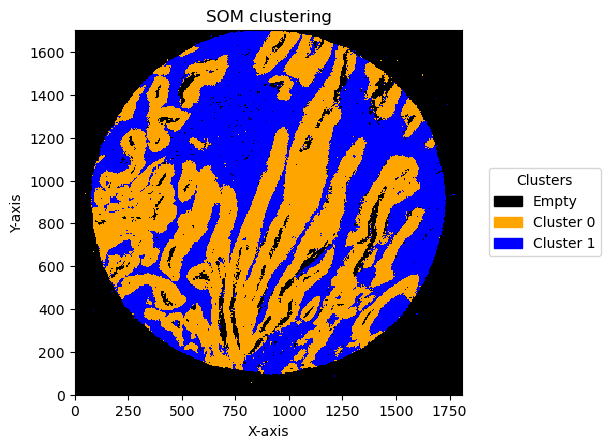

In [26]:
import matplotlib.colors as mcolors
import squidpy as sq

som_images = GC.get_som_2d_image(bin_size = 5)

# Create a custom colormap and legends 
cmap = mcolors.ListedColormap(['black', 'orange', 'blue',])
legend_labels = {0: 'Empty', 1: 'Cluster 0', 2: 'Cluster 1'}

for name, som_image in som_images.items():
    print(name)
    GC.plot_som(som_image, cmap = cmap, path=None, show=True, figsize=(5, 5), ax=None, legend_labels=legend_labels)

TMA1_Selection22


/home/martinha/miniconda3/envs/GRIDGEN/lib/python3.11/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/home/martinha/miniconda3/envs/GRIDGEN/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


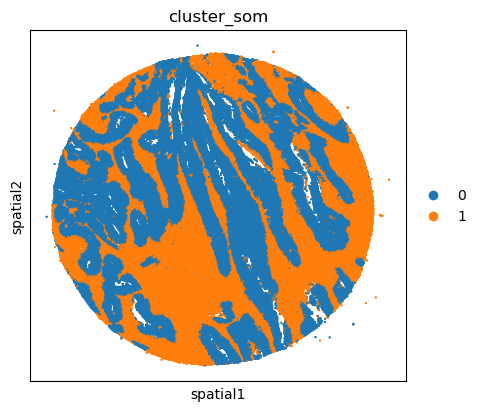

In [27]:
# adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()
unique_cases =adata.obs['name'].unique()
for case in unique_cases:
    # Filter the AnnData object for the current case
    adata_case = adata[adata.obs['name'] == case, :]
    print(case)
    plt.rcParams["figure.figsize"] = (5, 4)
    sq.pl.spatial_scatter(
            adata_case,
            library_id='name',
            shape=None,
            color=["cluster_som"],
            size=1,
    )
    plt.show()

We can use this information to build masks as we saw based on the contours defined by genes. 

SOM clusters are numbered. one needs to identify the identity of these clusters. from GC.eval_som_statistical(top_n=10), we can see that cluster 0 is Stroma (SPARC,  COL1A1, VIM ... ) and 1 is tumour (EPCAM, KRT18, KRT8 ...)

2025-06-20 15:34:17,418 - gridgen.get_masks.GetMasks - INFO - Initialized GetMasks


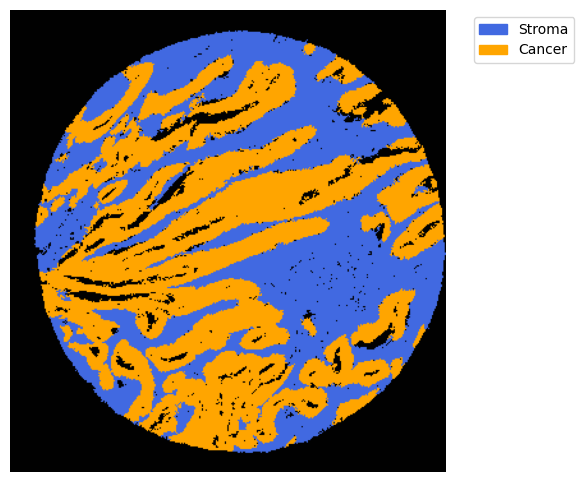

In [29]:
name, som_image = list(som_images.items())[0]
# pass the contour area threshold
GM = get_masks.GetMasks(image_shape = (som_image.shape[0], som_image.shape[1]))
mask_S = (som_image==2).astype(np.uint8) * 255
GM.mask_S = (GM.filter_binary_mask_by_area(mask_S, min_area=700))
mask_T = (som_image==1).astype(np.uint8) * 255
GM.mask_T = (GM.filter_binary_mask_by_area(mask_T, min_area=700))

GM.plot_masks(masks=[GM.mask_S, GM.mask_T], mask_names = ['Stroma', 'Cancer'],
          background_color=(1, 1, 1), 
              mask_colors={'Stroma': (65, 105, 225), 'Cancer': (255, 165, 0)},   # {'Stroma': (0, 0, 255), 'Tumour': (255, 0, 0)
              figsize= (6,6),
              path=None, show=True, ax=None)

With the masks, we can proceed and do the remaining pipeline with expansions, resuming mask information and hierarchy analysis as described in other notebooks.  Important parameters include the bin size and the number of units in SOM (see appropriate notebook).

***Effect of bin size and number of units***

In this pipeline there are things that can change the result. 
One is the bin size and the second one is the number of units in SOM . 

We can see the result effect of changing the bin size below: 

In [31]:
cmap = mcolors.ListedColormap(['black', 'blue', 'orange'])
legend_labels = {0: 'Empty', 1: 'Cluster 0', 2: 'Cluster 1'}
plot_data = []

for bin_size in [5,10,15,20,30,50,70]:
    min_counts = bin_size *3 
    unique_targets = df_total['target'].unique()
    
    GB = GetBins(bin_size, unique_targets, logger)
    GB.get_bin_cohort(df_list= [df_total], df_name_list = [name_file], cohort_name = 'HLA')
    GB.preprocess_bin(min_counts = min_counts)
    adata = GB.adata
    GC = GetContour(adata, logger)
    GC.run_som(som_shape = (2,1), n_iter = 5000, sigma=.5, learning_rate=.5, random_state = 42)
    
    som_image = GC.get_som_2d_image(bin_size)
    plot_data.append((som_image, bin_size))

2025-06-20 15:35:37,545 - contour_logger - INFO - Time to get bins for 1 dataframes: 2.13 seconds
2025-06-20 15:35:37,546 - contour_logger - INFO - Number of bins: 99374
2025-06-20 15:35:37,546 - contour_logger - INFO - Number of genes: 480
2025-06-20 15:35:38,930 - contour_logger - INFO - Time to run som on 76725 bins: 0.93
2025-06-20 15:35:38,931 - contour_logger - INFO - Number of clusters: 2
2025-06-20 15:35:38,932 - contour_logger - INFO - number of bins in each cluster: cluster_som
0    41714
1    35011
Name: count, dtype: int64
2025-06-20 15:35:43,033 - contour_logger - INFO - Time to get bins for 1 dataframes: 1.44 seconds
2025-06-20 15:35:43,034 - contour_logger - INFO - Number of bins: 28640
2025-06-20 15:35:43,034 - contour_logger - INFO - Number of genes: 480
2025-06-20 15:35:43,525 - contour_logger - INFO - Time to run som on 20234 bins: 0.36
2025-06-20 15:35:43,526 - contour_logger - INFO - Number of clusters: 2
2025-06-20 15:35:43,527 - contour_logger - INFO - number of 

Plotting bin size: 5, SOM name: TMA1_Selection22


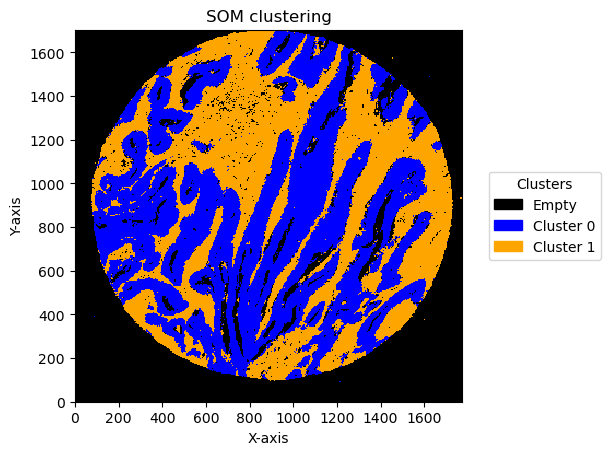

Plotting bin size: 10, SOM name: TMA1_Selection22


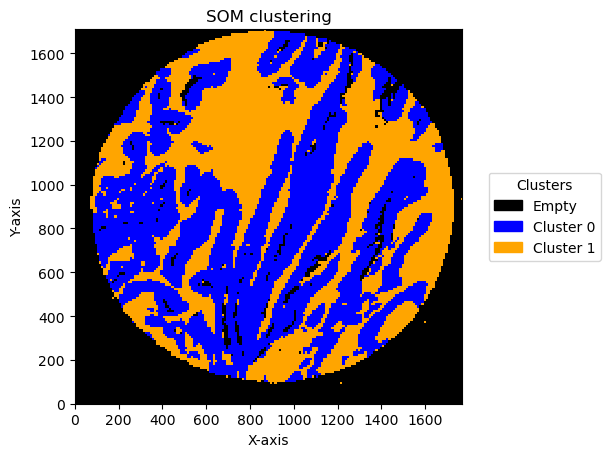

Plotting bin size: 15, SOM name: TMA1_Selection22


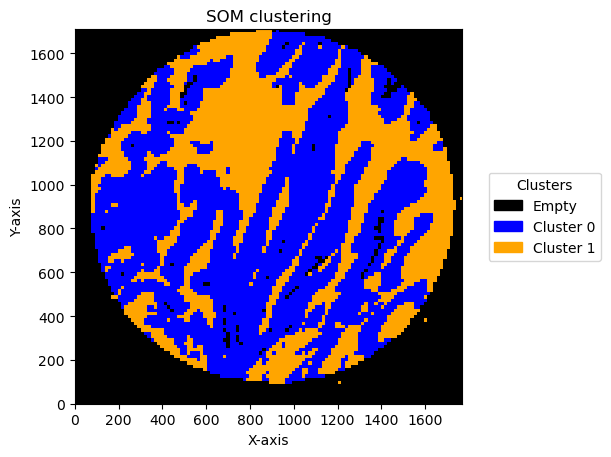

Plotting bin size: 20, SOM name: TMA1_Selection22


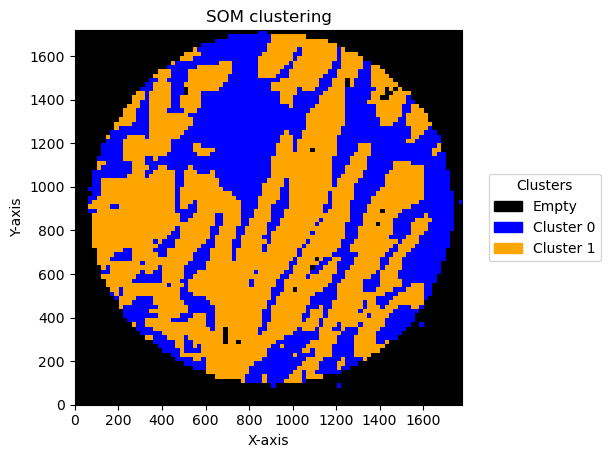

Plotting bin size: 30, SOM name: TMA1_Selection22


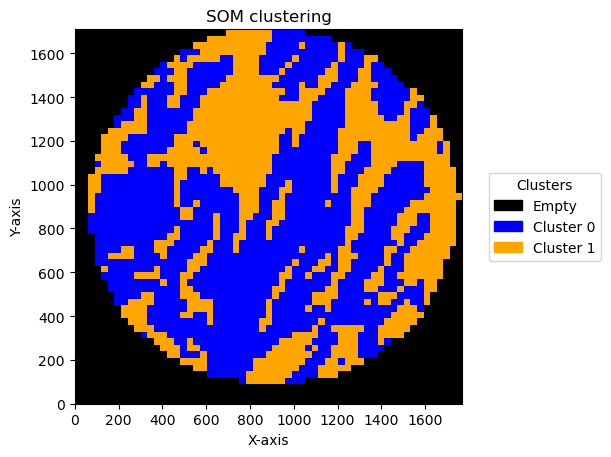

Plotting bin size: 50, SOM name: TMA1_Selection22


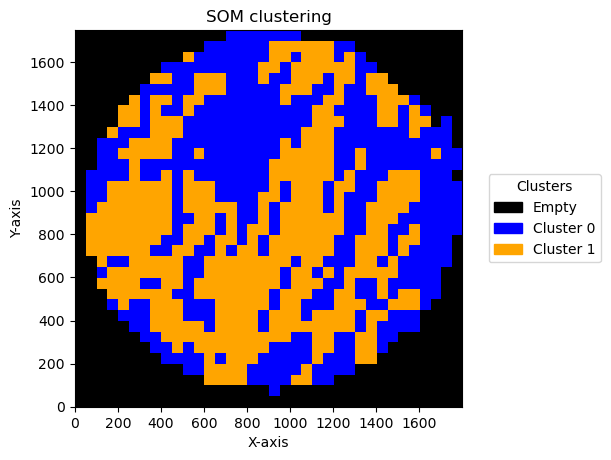

Plotting bin size: 70, SOM name: TMA1_Selection22


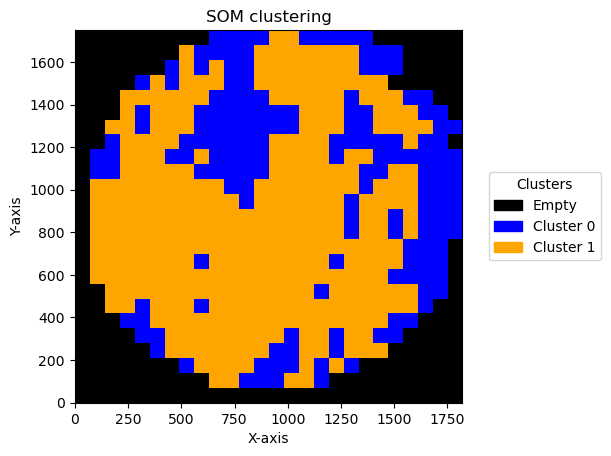

In [32]:
for som_image, bin_size in plot_data:
    for name, image in som_image.items():
        print(f"Plotting bin size: {bin_size}, SOM name: {name}")
        GC.plot_som(image, cmap=cmap, path=None, show=True, figsize=(5, 5), ax=None, legend_labels=legend_labels)

check how the number of units and distribution on the SOM map can reflect in the clusters obtained

In [33]:
cmap = mcolors.ListedColormap(['black', 'blue', 'orange'])
legend_labels = {0: 'Empty', 1: 'Cluster 0', 2: 'Cluster 1'}
plot_data = []

for som_size in [(2,1), (3,1), (2,2),(3,3), (5,2)]:
    bin_size = 10
    min_counts = 20 
    unique_targets = df_total['target'].unique()
    
    GB = GetBins(bin_size, unique_targets, logger)
    GB.get_bin_cohort(df_list= [df_total], df_name_list = [name_file], cohort_name = 'HLA')
    GB.preprocess_bin(min_counts = min_counts)
    adata = GB.adata
    GC = GetContour(adata, logger)
    GC.run_som(som_shape = som_size, n_iter = 5000, sigma=.5, learning_rate=.5, random_state = 42)
    
    som_image = GC.get_som_2d_image(bin_size)
    plot_data.append((som_image, bin_size))

2025-06-20 15:36:47,109 - contour_logger - INFO - Time to get bins for 1 dataframes: 1.39 seconds
2025-06-20 15:36:47,109 - contour_logger - INFO - Number of bins: 28640
2025-06-20 15:36:47,109 - contour_logger - INFO - Number of genes: 480
2025-06-20 15:36:47,593 - contour_logger - INFO - Time to run som on 20450 bins: 0.35
2025-06-20 15:36:47,593 - contour_logger - INFO - Number of clusters: 2
2025-06-20 15:36:47,594 - contour_logger - INFO - number of bins in each cluster: cluster_som
0    11561
1     8889
Name: count, dtype: int64
2025-06-20 15:36:49,934 - contour_logger - INFO - Time to get bins for 1 dataframes: 1.52 seconds
2025-06-20 15:36:49,934 - contour_logger - INFO - Number of bins: 28640
2025-06-20 15:36:49,934 - contour_logger - INFO - Number of genes: 480
2025-06-20 15:36:50,432 - contour_logger - INFO - Time to run som on 20450 bins: 0.36
2025-06-20 15:36:50,432 - contour_logger - INFO - Number of clusters: 3
2025-06-20 15:36:50,433 - contour_logger - INFO - number of 

Plotting bin size: 10, SOM name: TMA1_Selection22


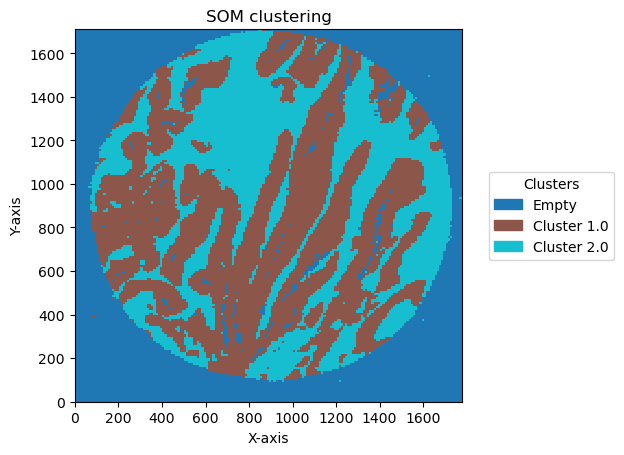

Plotting bin size: 10, SOM name: TMA1_Selection22


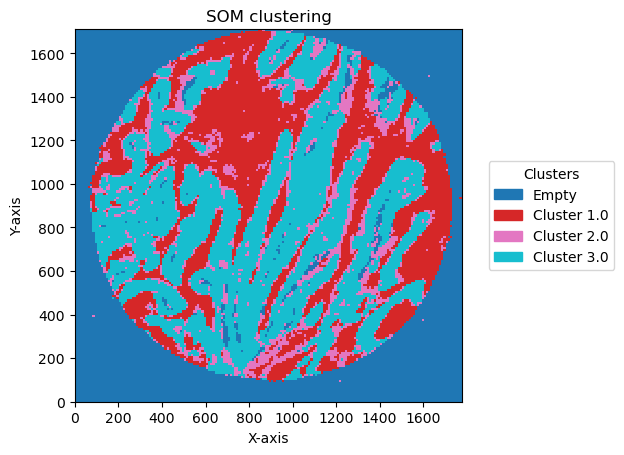

Plotting bin size: 10, SOM name: TMA1_Selection22


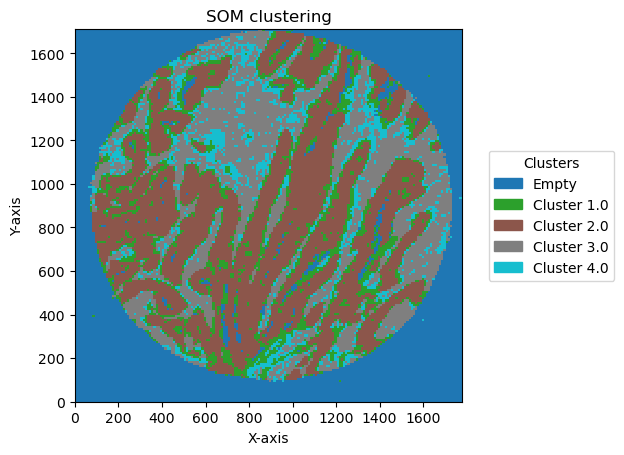

Plotting bin size: 10, SOM name: TMA1_Selection22


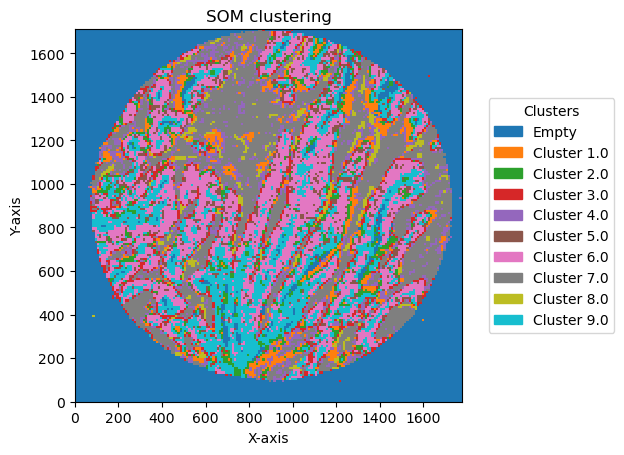

Plotting bin size: 10, SOM name: TMA1_Selection22


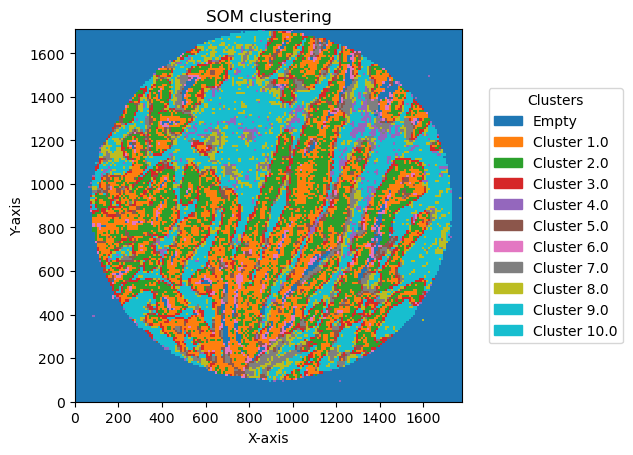

In [34]:
for som_image, bin_size in plot_data:
    for name, image in som_image.items():
        # Get unique clusters from your data (e.g., via np.unique(cluster_data))
        unique_clusters = np.unique(image)
        
        # Create the legend_labels dictionary only for detected clusters
        legend_labels = {i: f'Cluster {i}' for i in unique_clusters}
        
        # Optional: set specific labels if certain clusters have special meanings
        if 0 in unique_clusters:
            legend_labels[0] = 'Empty'
        print(f"Plotting bin size: {bin_size}, SOM name: {name}")
        GC.plot_som(image, cmap=plt.cm.tab10, path=None, show=True, figsize=(5, 5), ax=None, legend_labels=legend_labels)